## Objectives

Shared VO estimates are absolute estimates, which is cumulatively multiplied using pose in a previous frame and the current relative pose estimation. This notebook computes relative vo pose and save it in csv format.

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import Image

sys.path.append('/app/src')

from src.internal.extended_common import (
    CoordinateFrame,
    Pose, State,
    ExtendedConfig,
    KITTI_SEQUENCE_TO_DATE,
    KITTI_SEQUENCE_TO_DRIVE
)
from src.internal.dataset import OXTS_GPSDataReader
from src.common.datatypes import State, Pose
from src.utils.geometric_transformer import GeometryTransformer, TransformationField
from src.utils.geometric_transformer.base_geometric_transformer import BaseGeometryTransformer

warnings.filterwarnings("ignore")

In [19]:
sequence = '07'
stereo_vo_path = '/app/data/KITTI/vo_pose_estimates_stereo'
drive = KITTI_SEQUENCE_TO_DRIVE.get(sequence, '2011_09_26_drive_0005_sync')
date = KITTI_SEQUENCE_TO_DATE.get(sequence, '2011_09_26')

vo_data = pd.read_csv(os.path.join(stereo_vo_path, date, drive, 'data.txt'), header=None, sep=' ').values.reshape(-1, 3, 4)
vo_data.shape


(1099, 3, 4)

In [21]:
vo_relative_poses = []
for vo_prev, vo_next in zip(vo_data[:-1], vo_data[1:]):
    vo_prev_pose = np.eye(4)
    vo_prev_pose[:3, :] = vo_prev
    vo_next_pose = np.eye(4)
    vo_next_pose[:3, :] = vo_next
    relative_pose = np.linalg.inv(vo_prev_pose) @ vo_next_pose
    vo_relative_poses.append(relative_pose)
    print(relative_pose)
    print('---')

vo_relative_poses = np.array(vo_relative_poses)
vo_relative_poses.shape

[[ 9.99977127e-01  5.69623816e-04 -6.73955442e-03 -1.41781041e-02]
 [-5.69664081e-04  9.99999838e-01 -4.05491162e-06 -2.54193835e-03]
 [ 6.73955102e-03  7.89410095e-06  9.99977289e-01  9.28769703e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
---
[[ 9.99971836e-01  2.66028295e-04 -7.50043488e-03 -1.04087354e-02]
 [-2.71217740e-04  9.99999725e-01 -6.90877281e-04 -1.11878574e-03]
 [ 7.50024903e-03  6.92892074e-04  9.99971633e-01  9.77127485e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
---
[[ 9.99958091e-01  6.02941037e-04 -9.13528901e-03 -1.30801111e-02]
 [-6.15794525e-04  9.99998824e-01 -1.40426751e-03 -5.04788655e-04]
 [ 9.13443158e-03  1.40983412e-03  9.99957286e-01  1.03606943e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
---
[[ 9.99935371e-01  2.05084926e-04 -1.13671222e-02 -1.57364158e-02]
 [-2.22909118e-04  9.99998748e-01 -1.56680310e-03 -8.87515351e-04]
 [ 1.13667866e-02  1.56923567e-03  9.99934165e-

(1098, 4, 4)

In [22]:
current_pose = np.eye(4)
vo_pose_recovery = [current_pose.copy()[:3, :]]
for relative_pose in vo_relative_poses:
    current_pose = current_pose @ relative_pose
    vo_pose_recovery.append(current_pose.copy()[:3, :])

vo_pose_recovery = np.array(vo_pose_recovery)
vo_pose_recovery.shape

(1099, 3, 4)

In [17]:
gps_data_reader = OXTS_GPSDataReader(
    root_path='/app/data/KITTI/',
    date=date,
    drive=drive
)
config = ExtendedConfig(config_filepath="/app/configs/kitti_config.yaml")
transformer = GeometryTransformer(config.hardware)
state = State(p=np.zeros((3, 1)), v=np.zeros((3, 1)), q=np.array([1, 0, 0, 0]).reshape(-1, 1), b_w=np.zeros((3, 1)), b_a=np.zeros((3, 1)))

gps_data = iter(gps_data_reader)
gps_camera = []
for item in gps_data:
    z = np.array([item.lon, item.lat, item.alt])
    _gps = transformer.transform(
        fields=TransformationField(
            state=state,
            value=z,
            coord_from=CoordinateFrame.GPS,
            coord_to=CoordinateFrame.INERTIAL,
        )
    )
    _gps = transformer.transform(
        fields=TransformationField(
            state=state,
            value=_gps.flatten(),
            coord_from=CoordinateFrame.INERTIAL,
            coord_to=CoordinateFrame.STEREO_LEFT,
        )
    )
    gps_camera.append(_gps.flatten())

gps_camera = np.array(gps_camera)
gps_camera.shape

ERROR:root:Angle compensation for KITTI sequence 07: 0.5641313911083438 rad


(1106, 3)

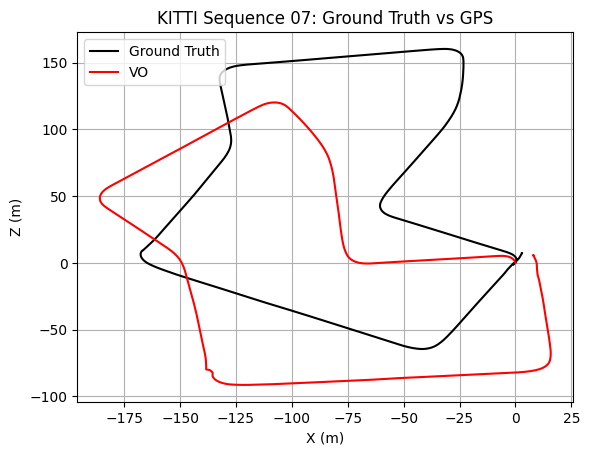

In [23]:
px, py, pz = gps_camera.T
plt.plot(px, pz, label='Ground Truth', color='black')
px, py, pz = vo_pose_recovery[:, :3, 3].T
plt.plot(px, pz, label='VO', color='red')
plt.legend()
plt.xlabel('X (m)')
plt.ylabel('Z (m)')
plt.title(f'KITTI Sequence {sequence}: Ground Truth vs GPS')
plt.grid()

In [27]:
for i, sequence in enumerate(['01', '02', '03', '04', '05', '06', '07', '08', '09']):
    drive = KITTI_SEQUENCE_TO_DRIVE.get(sequence, '2011_09_26_drive_0005_sync')
    date = KITTI_SEQUENCE_TO_DATE.get(sequence, '2011_09_26')
    data_path = os.path.join(stereo_vo_path, date, drive)

    vo_data = pd.read_csv(os.path.join(data_path, 'data.txt'), header=None, sep=' ').values.reshape(-1, 3, 4)
    vo_data.shape
    vo_relative_poses = []
    for vo_prev, vo_next in zip(vo_data[:-1], vo_data[1:]):
        vo_prev_pose = np.eye(4)
        vo_prev_pose[:3, :] = vo_prev
        vo_next_pose = np.eye(4)
        vo_next_pose[:3, :] = vo_next
        relative_pose = np.linalg.inv(vo_prev_pose) @ vo_next_pose
        vo_relative_poses.append(relative_pose.copy()[:3, :].flatten())

    vo_relative_poses = np.array(vo_relative_poses)
    pd.DataFrame(vo_relative_poses).to_csv(os.path.join(data_path, 'data.csv'), header=None, index=None)